# Análisis de Series de Tiempo - Bitcoin
## Trabajo Final - UBA Especialización en IA

**Pregunta de Investigación:**  
*¿Cómo han evolucionado los patrones de volatilidad del Bitcoin desde su creación y qué modelos de series de tiempo predicen mejor sus movimientos de precio a corto y mediano plazo?*

---

### Integrantes del grupo:
- Nombre 1 - Código: XXXXX
- Nombre 2 - Código: XXXXX
- Nombre 3 - Código: XXXXX
- Nombre 4 - Código: XXXXX

## 1. Importar Librerías

In [3]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.options.display.float_format = '{:.2f}'.format

# Ignorar warnings
import warnings
warnings.filterwarnings('ignore')

print("Librerías importadas correctamente")

Librerías importadas correctamente


## 2. Cargar y Explorar los Datos

### 2.1 Descripción de los Datos

**Fuente:** Yahoo Finance / Kaggle  
**Periodo:** 2014 - 2025  
**Frecuencia:** Diaria

**Atributos del dataset:**
- **Date:** Fecha de la observación (tipo: datetime)
- **Open:** Precio de apertura en USD (tipo: float)
- **High:** Precio máximo del día en USD (tipo: float)
- **Low:** Precio mínimo del día en USD (tipo: float)
- **Close:** Precio de cierre en USD (tipo: float) - **Variable principal de análisis**
- **Adj Close:** Precio de cierre ajustado en USD (tipo: float)
- **Volume:** Volumen de transacciones (tipo: int)

In [4]:
# Cargar datos
# NOTA: Primero debes descargar los datos ejecutando: python descargar_datos.py
# O descarga manualmente desde https://finance.yahoo.com/quote/BTC-USD/history

df = pd.read_csv('../data/raw/bitcoin_historical.csv')

# Convertir fecha a datetime
df['Date'] = pd.to_datetime(df['Date'])

# Establecer fecha como índice
df.set_index('Date', inplace=True)

# Ordenar por fecha
df.sort_index(inplace=True)

print(f"Dataset cargado: {df.shape[0]} observaciones, {df.shape[1]} variables")
print(f"Periodo: {df.index.min()} a {df.index.max()}")

df.head()

Dataset cargado: 2001 observaciones, 5 variables
Periodo: 2020-04-14 00:00:00 a 2025-10-05 00:00:00


,Open,High,Low,Close,Volume
Date,,,,,
2020-04-14,6879.44,6937.49,6614.79,6629.54,49708.81
2020-04-15,6629.54,7207.11,6487.08,7114.55,98809.08
2020-04-16,7114.55,7155.17,7005.79,7037.12,45840.75
2020-04-17,7037.12,7304.35,7028.43,7264.29,35919.74
2020-04-18,7264.29,7276.84,7072.33,7132.88,29493.83


In [5]:
# Información general del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2001 entries, 2020-04-14 to 2025-10-05
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2001 non-null   float64
 1   High    2001 non-null   float64
 2   Low     2001 non-null   float64
 3   Close   2001 non-null   float64
 4   Volume  2001 non-null   float64
dtypes: float64(5)
memory usage: 93.8 KB


In [6]:
# Estadísticas descriptivas
df.describe()

,Open,High,Low,Close,Volume
count,2001.00,2001.00,2001.00,2001.00,2001.00
mean,46992.52,47969.44,45976.58,47050.82,38290.41
std,29699.25,30149.60,29247.92,29734.96,26466.46
min,6629.54,6937.49,6487.08,6629.54,3465.16
25%,23492.86,24125.33,23038.65,23533.22,20540.56
50%,40030.52,41400.48,38933.24,40078.62,32545.30
75%,63149.43,64335.08,61631.05,63168.44,48151.29
max,123535.21,125748.81,123143.47,123542.74,290986.06


## 3. Limpieza y Preparación de los Datos

In [7]:
# Verificar valores nulos
print("Valores nulos por columna:")
print(df.isnull().sum())

# Rellenar valores nulos si existen (método forward fill)
if df.isnull().any().any():
    df.fillna(method='ffill', inplace=True)
    print("\nValores nulos rellenados con forward fill")

Valores nulos por columna:
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [8]:
# Crear variables derivadas útiles para el análisis

# Retornos diarios
df['Returns'] = df['Close'].pct_change()

# Volatilidad (desviación estándar móvil de 30 días)
df['Volatility_30d'] = df['Returns'].rolling(window=30).std()

# Media móvil simple (SMA)
df['SMA_7'] = df['Close'].rolling(window=7).mean()
df['SMA_30'] = df['Close'].rolling(window=30).mean()
df['SMA_90'] = df['Close'].rolling(window=90).mean()

# Rango diario (High - Low)
df['Daily_Range'] = df['High'] - df['Low']

print("Variables derivadas creadas")
df.head()

Variables derivadas creadas


,Open,High,Low,Close,Volume,Returns,Volatility_30d,SMA_7,SMA_30,SMA_90,Daily_Range
Date,,,,,,,,,,,
2020-04-14,6879.44,6937.49,6614.79,6629.54,49708.81,NaN,NaN,NaN,NaN,NaN,322.70
2020-04-15,6629.54,7207.11,6487.08,7114.55,98809.08,0.07,NaN,NaN,NaN,NaN,720.03
2020-04-16,7114.55,7155.17,7005.79,7037.12,45840.75,-0.01,NaN,NaN,NaN,NaN,149.38
2020-04-17,7037.12,7304.35,7028.43,7264.29,35919.74,0.03,NaN,NaN,NaN,NaN,275.92
2020-04-18,7264.29,7276.84,7072.33,7132.88,29493.83,-0.02,NaN,NaN,NaN,NaN,204.51


In [9]:
# Guardar datos procesados
df.to_csv('../data/processed/bitcoin_processed.csv')
print("Datos procesados guardados en: data/processed/bitcoin_processed.csv")

Datos procesados guardados en: data/processed/bitcoin_processed.csv


## 4. Análisis Exploratorio Visual

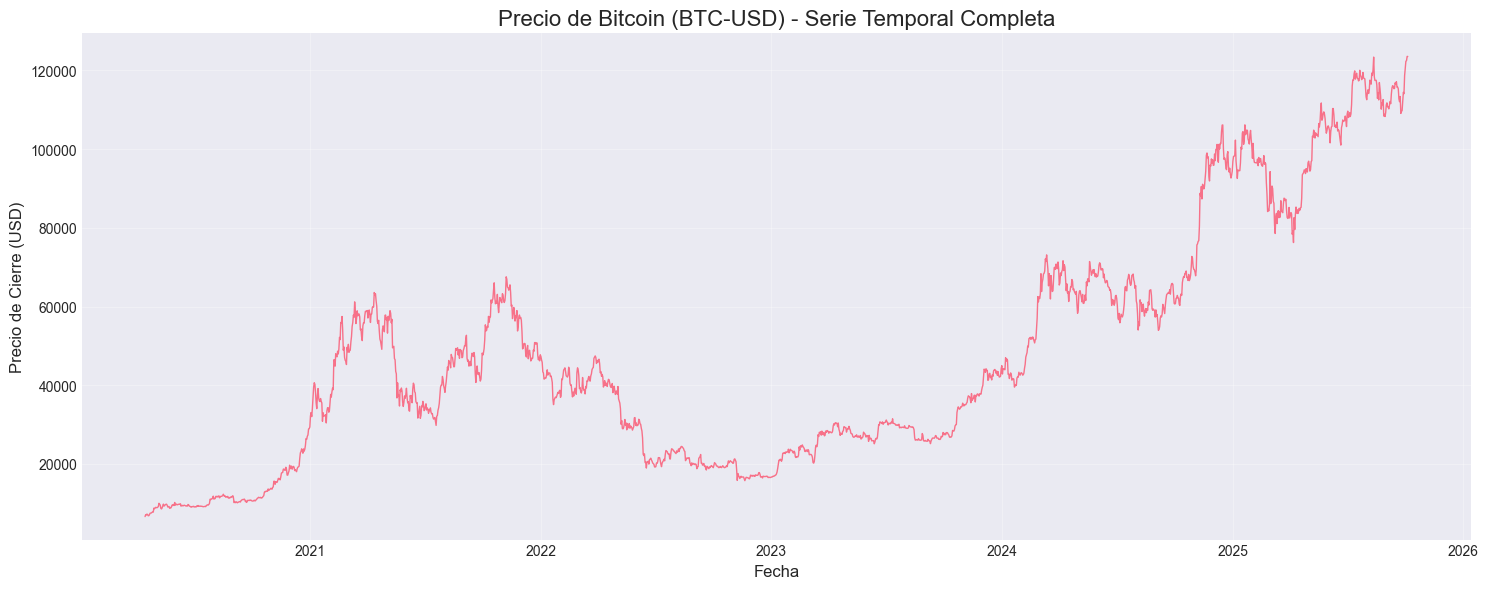

In [10]:
# Gráfica de precio de cierre
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Close'], linewidth=1)
plt.title('Precio de Bitcoin (BTC-USD) - Serie Temporal Completa', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio de Cierre (USD)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

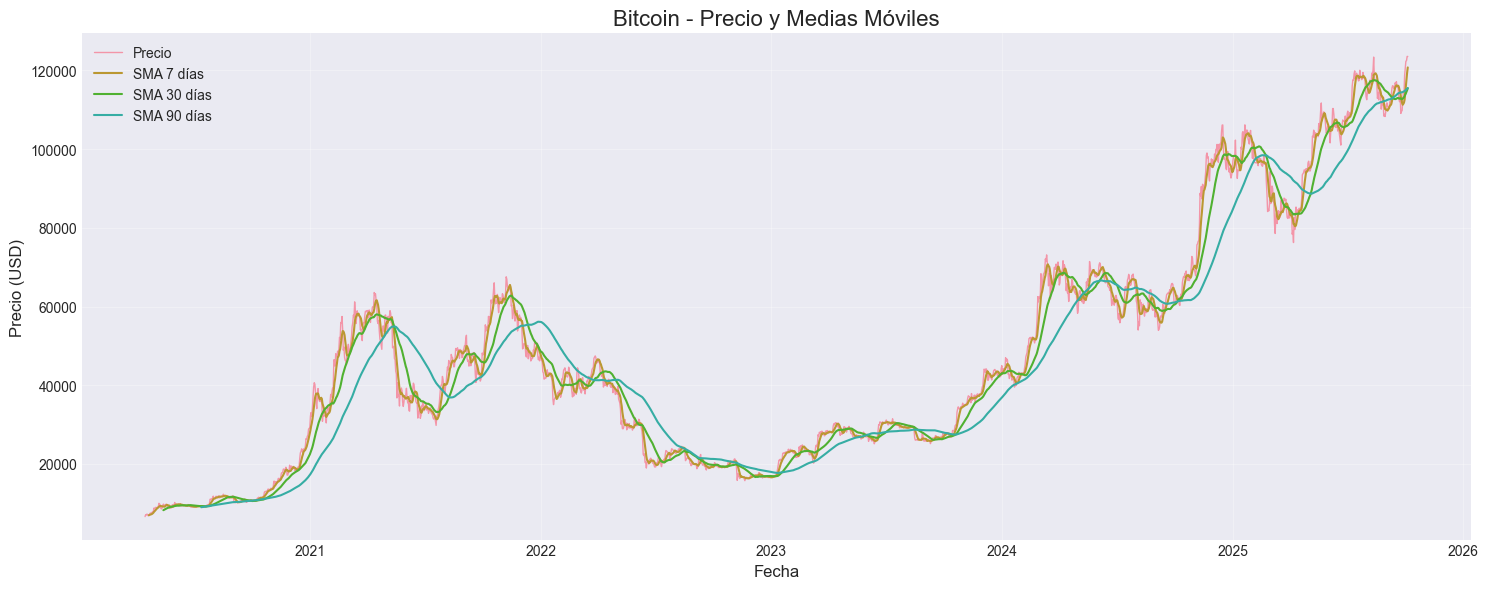

In [11]:
# Precio con medias móviles
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Close'], label='Precio', linewidth=1, alpha=0.7)
plt.plot(df.index, df['SMA_7'], label='SMA 7 días', linewidth=1.5)
plt.plot(df.index, df['SMA_30'], label='SMA 30 días', linewidth=1.5)
plt.plot(df.index, df['SMA_90'], label='SMA 90 días', linewidth=1.5)
plt.title('Bitcoin - Precio y Medias Móviles', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio (USD)', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

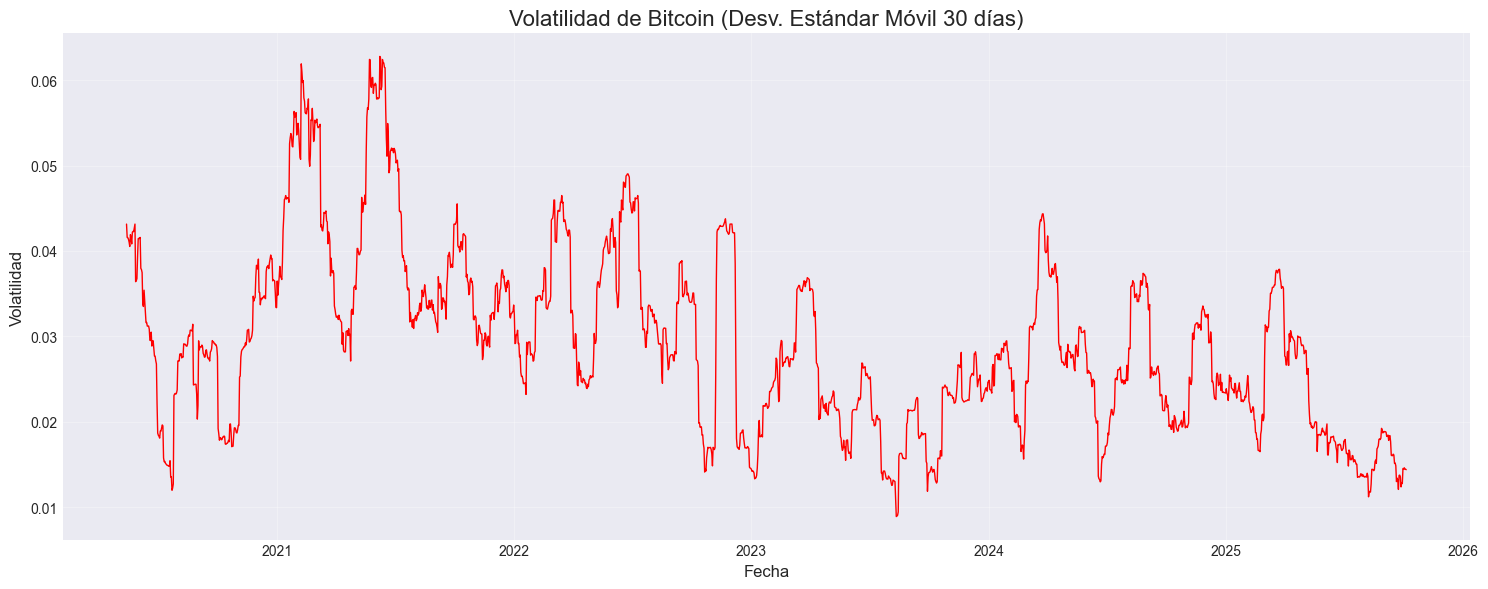

In [12]:
# Volatilidad en el tiempo
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Volatility_30d'], color='red', linewidth=1)
plt.title('Volatilidad de Bitcoin (Desv. Estándar Móvil 30 días)', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Volatilidad', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

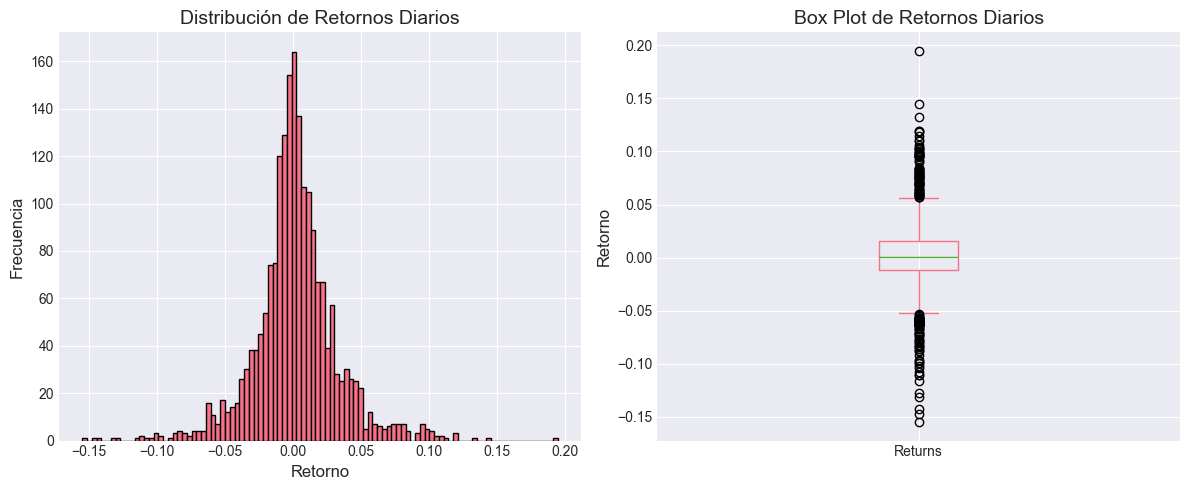

Media de retornos: 0.0019
Desviación estándar: 0.0311


In [13]:
# Distribución de retornos diarios
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df['Returns'].hist(bins=100, edgecolor='black')
plt.title('Distribución de Retornos Diarios', fontsize=14)
plt.xlabel('Retorno', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)

plt.subplot(1, 2, 2)
df['Returns'].plot(kind='box', vert=True)
plt.title('Box Plot de Retornos Diarios', fontsize=14)
plt.ylabel('Retorno', fontsize=12)

plt.tight_layout()
plt.show()

print(f"Media de retornos: {df['Returns'].mean():.4f}")
print(f"Desviación estándar: {df['Returns'].std():.4f}")

## 5. Análisis de Estacionariedad

In [14]:
# Test de Dickey-Fuller Aumentado (ADF)
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, title):
    # Test ADF
    result = adfuller(timeseries.dropna())
    
    print(f'\n{title}')
    print('='*60)
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Valores críticos:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print("\n✓ La serie ES estacionaria (rechazamos H0)")
    else:
        print("\n✗ La serie NO es estacionaria (no rechazamos H0)")

# Test en precio original
test_stationarity(df['Close'], 'Test de Estacionariedad - Precio')

# Test en retornos
test_stationarity(df['Returns'], 'Test de Estacionariedad - Retornos')


Test de Estacionariedad - Precio
ADF Statistic: -0.039105
p-value: 0.955176
Valores críticos:
	1%: -3.434
	5%: -2.863
	10%: -2.568

✗ La serie NO es estacionaria (no rechazamos H0)

Test de Estacionariedad - Retornos
ADF Statistic: -46.746505
p-value: 0.000000
Valores críticos:
	1%: -3.434
	5%: -2.863
	10%: -2.568

✓ La serie ES estacionaria (rechazamos H0)


## 6. Autocorrelación (ACF y PACF)

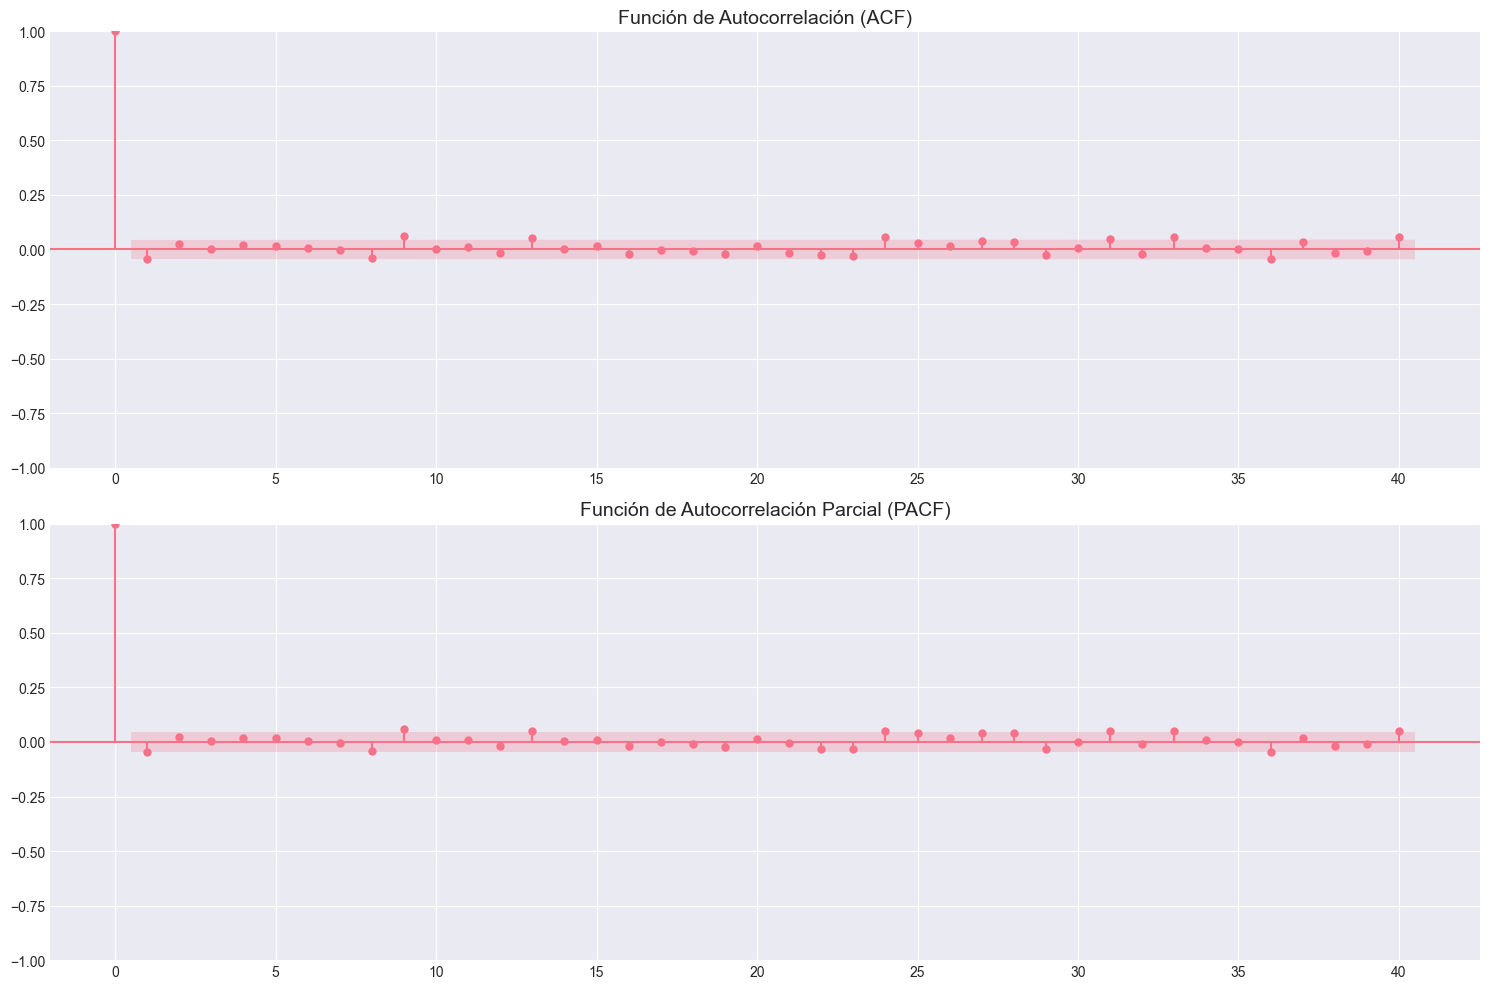

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Preparar datos (eliminar NaN)
returns_clean = df['Returns'].dropna()

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# ACF
plot_acf(returns_clean, lags=40, ax=axes[0])
axes[0].set_title('Función de Autocorrelación (ACF)', fontsize=14)

# PACF
plot_pacf(returns_clean, lags=40, ax=axes[1])
axes[1].set_title('Función de Autocorrelación Parcial (PACF)', fontsize=14)

plt.tight_layout()
plt.show()

## 7. Descomposición de la Serie

Descomponemos la serie en: Tendencia, Estacionalidad y Residuos

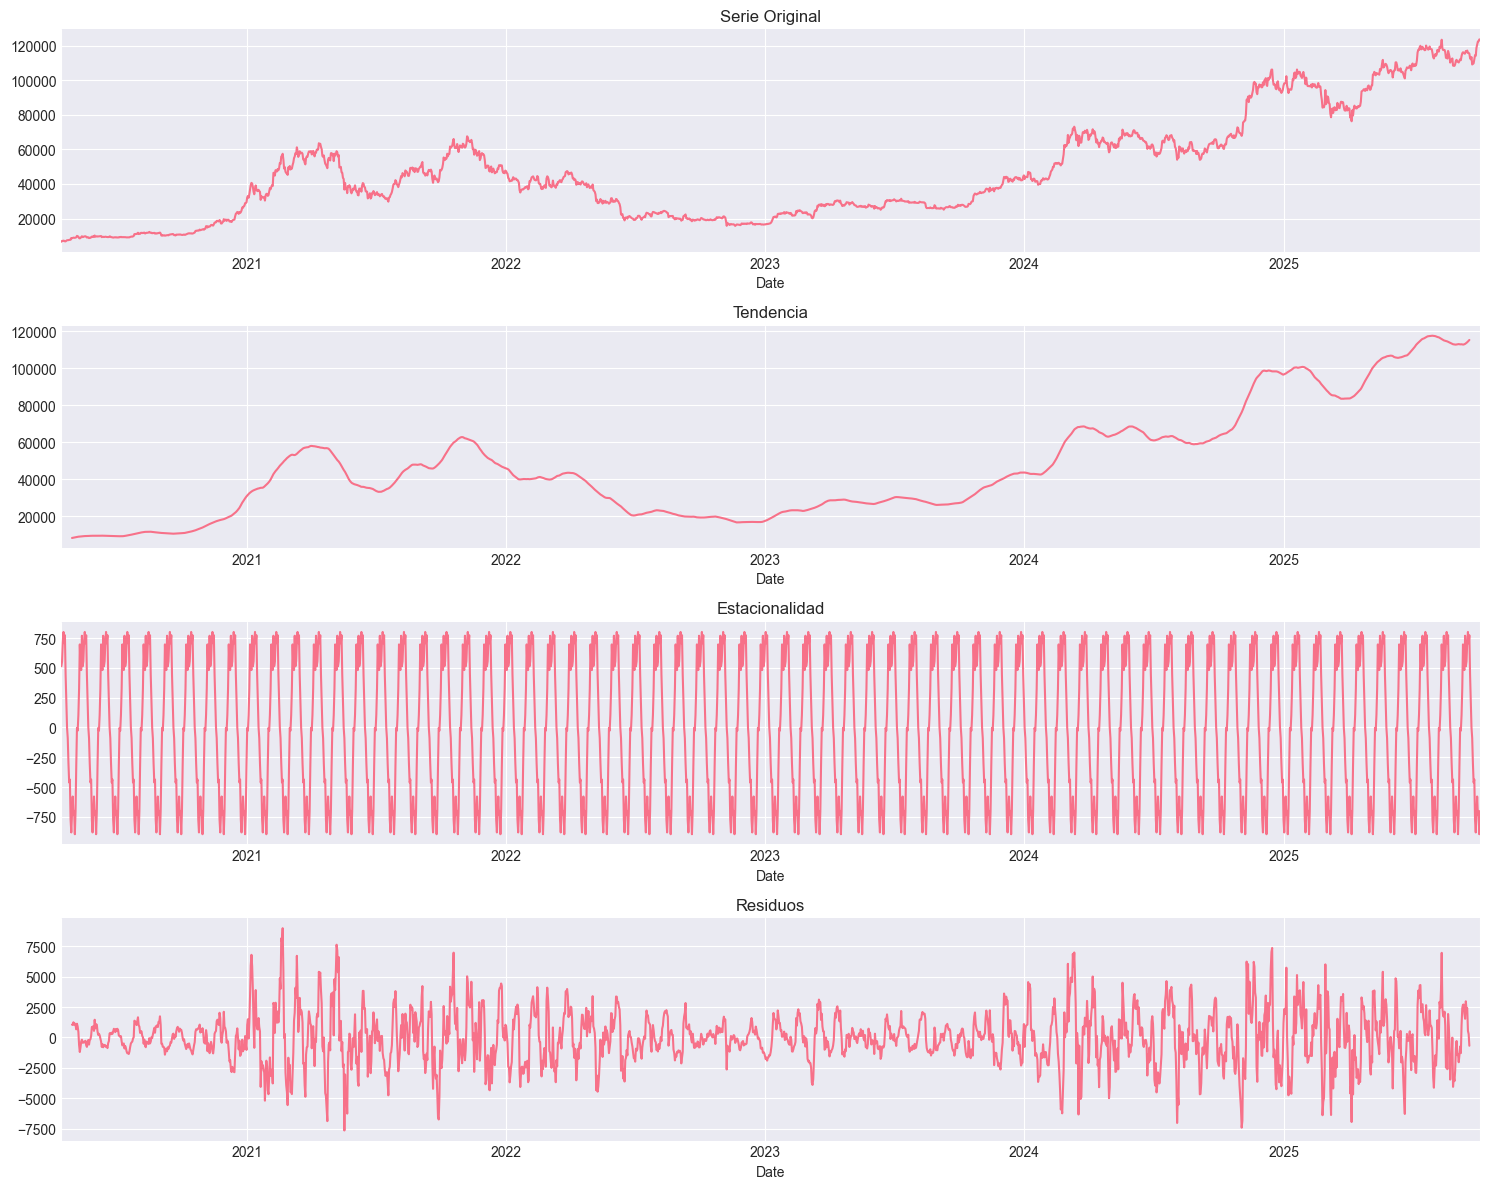

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomposición aditiva
decomposition = seasonal_decompose(df['Close'].dropna(), model='additive', period=30)

fig, axes = plt.subplots(4, 1, figsize=(15, 12))

decomposition.observed.plot(ax=axes[0], title='Serie Original')
decomposition.trend.plot(ax=axes[1], title='Tendencia')
decomposition.seasonal.plot(ax=axes[2], title='Estacionalidad')
decomposition.resid.plot(ax=axes[3], title='Residuos')

plt.tight_layout()
plt.show()

## 8. División de Datos: Train/Test

Dividimos los datos en conjunto de entrenamiento (80%) y prueba (20%)

Tamaño del conjunto de entrenamiento: 1600
Tamaño del conjunto de prueba: 401

Periodo de entrenamiento: 2020-04-14 00:00:00 a 2024-08-30 00:00:00
Periodo de prueba: 2024-08-31 00:00:00 a 2025-10-05 00:00:00


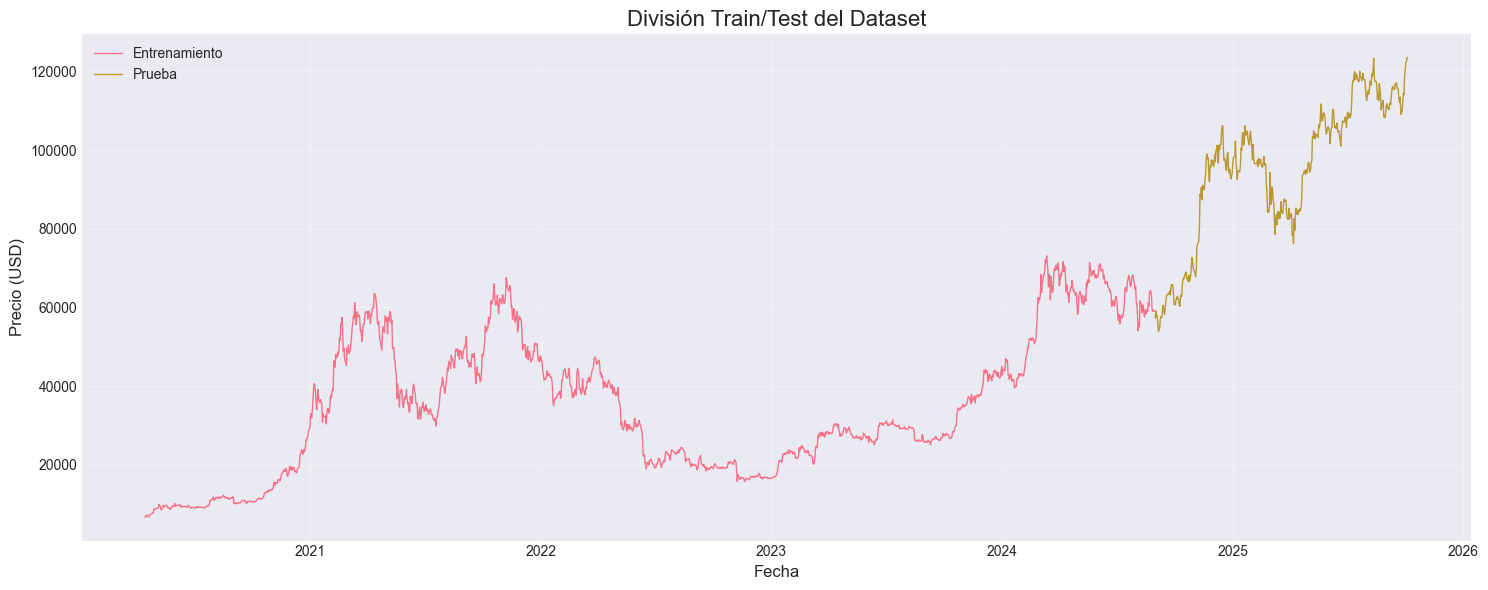

In [17]:
# Seleccionar solo la columna de precio de cierre
data = df['Close'].copy()

# Dividir en train/test (80/20)
train_size = int(len(data) * 0.8)
train = data[:train_size]
test = data[train_size:]

print(f"Tamaño del conjunto de entrenamiento: {len(train)}")
print(f"Tamaño del conjunto de prueba: {len(test)}")
print(f"\nPeriodo de entrenamiento: {train.index.min()} a {train.index.max()}")
print(f"Periodo de prueba: {test.index.min()} a {test.index.max()}")

# Visualizar división
plt.figure(figsize=(15, 6))
plt.plot(train.index, train, label='Entrenamiento', linewidth=1)
plt.plot(test.index, test, label='Prueba', linewidth=1)
plt.title('División Train/Test del Dataset', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio (USD)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Próximos Pasos

En los siguientes notebooks desarrollaremos:

1. **Notebook 02 - Modelo ARIMA/SARIMA:**
   - Identificación de parámetros (p, d, q)
   - Ajuste del modelo
   - Predicciones y evaluación

2. **Notebook 03 - Modelo LSTM (Deep Learning):**
   - Preparación de datos para redes neuronales
   - Arquitectura de red LSTM
   - Entrenamiento y predicción

3. **Notebook 04 - Modelo Prophet:**
   - Configuración del modelo Prophet de Facebook
   - Ajuste y pronósticos
   - Visualización de componentes

4. **Notebook 05 - Comparación de Modelos:**
   - Evaluación con métricas: RMSE, MAE, MAPE
   - Comparación visual
   - Conclusiones finales

## 10. Guardar Datos Preparados

In [18]:
# Guardar conjuntos de entrenamiento y prueba
train.to_csv('../data/processed/train.csv')
test.to_csv('../data/processed/test.csv')

print("Datos guardados:")
print("- data/processed/train.csv")
print("- data/processed/test.csv")

Datos guardados:
- data/processed/train.csv
- data/processed/test.csv
